In [1]:
import numpy as np
import sep
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams
import astropy.wcs as wcs

import matplotlib.patches as patches
from astropy.coordinates import match_coordinates_sky
import astropy.units as u
from astropy.coordinates import SkyCoord 
from astropy.table import Table
import pandas as pd
import warnings

warnings.filterwarnings('ignore')


rcParams['figure.figsize'] = [10., 8.]

In [2]:
baseurl = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/nircam_photometry/'
filepath = '../../ngc3324/NIRCAM_ALL_May112023/JWST/jw02731-o001_t017_nircam_'
filters = 'f090w f187n f200w f335m f444w f444w-f470n f770w f1130w f1280w f1800w'.split()

# Data images [e-/s]
imagefiles = {}
for r, filt in enumerate(filters):
    if r<5:
        filename = f'clear-{filt}/jw02731-o001_t017_nircam_clear-{filt}_i2d.fits'
        imagefiles[filt] = filepath + filename
    elif filt == 'f444w-f470n': 
        filename = f'{filt}/jw02731-o001_t017_nircam_{filt}_i2d.fits'
        imagefiles[filt] = filepath + filename
    else:
        filepath = '../../ngc3324/MIRI_ALL_May112023/JWST/jw02731-o002_t017_miri_'
        filename = f'{filt}/jw02731-o002_t017_miri_{filt}_i2d.fits'
        imagefiles[filt] = filepath + filename

    print(imagefiles[filt])

filt = 'f444w'
# infile = imagefiles[filt]
# hdu = fits.open(infile)
# data = hdu[1].data
# imwcs = wcs.WCS(hdu[1].header, hdu)

# spitz_name = '../../ngc3324/FITS/SPITZER_45.fits'
# hdu_spitz = fits.open(spitz_name)

../../ngc3324/NIRCAM_ALL_May112023/JWST/jw02731-o001_t017_nircam_clear-f090w/jw02731-o001_t017_nircam_clear-f090w_i2d.fits
../../ngc3324/NIRCAM_ALL_May112023/JWST/jw02731-o001_t017_nircam_clear-f187n/jw02731-o001_t017_nircam_clear-f187n_i2d.fits
../../ngc3324/NIRCAM_ALL_May112023/JWST/jw02731-o001_t017_nircam_clear-f200w/jw02731-o001_t017_nircam_clear-f200w_i2d.fits
../../ngc3324/NIRCAM_ALL_May112023/JWST/jw02731-o001_t017_nircam_clear-f335m/jw02731-o001_t017_nircam_clear-f335m_i2d.fits
../../ngc3324/NIRCAM_ALL_May112023/JWST/jw02731-o001_t017_nircam_clear-f444w/jw02731-o001_t017_nircam_clear-f444w_i2d.fits
../../ngc3324/NIRCAM_ALL_May112023/JWST/jw02731-o001_t017_nircam_f444w-f470n/jw02731-o001_t017_nircam_f444w-f470n_i2d.fits
../../ngc3324/MIRI_ALL_May112023/JWST/jw02731-o002_t017_miri_f770w/jw02731-o002_t017_miri_f770w_i2d.fits
../../ngc3324/MIRI_ALL_May112023/JWST/jw02731-o002_t017_miri_f1130w/jw02731-o002_t017_miri_f1130w_i2d.fits
../../ngc3324/MIRI_ALL_May112023/JWST/jw02731-o002

In [3]:

data = fits.open(imagefiles[filt])[1].data
wcs_im = wcs.WCS(fits.open(imagefiles[filt])[1].header)

data = data.byteswap(inplace=True).newbyteorder()

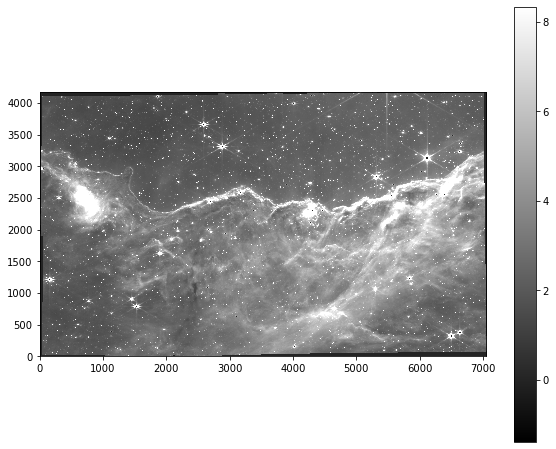

In [4]:
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();

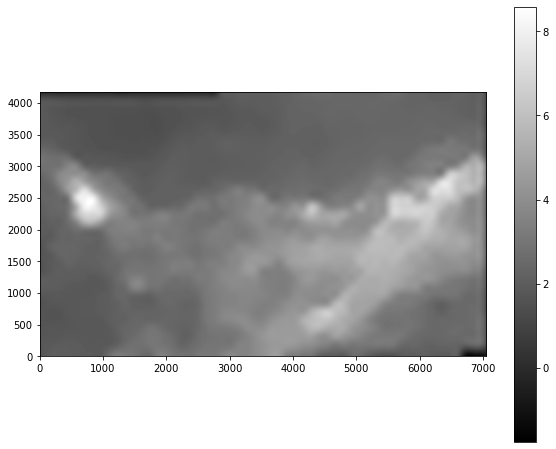

In [5]:
# measure a spatially varying background on the image
# bkg = sep.Background(data)
bkg = sep.Background(data, bw=128, bh=128, fw=3, fh=3)
bkg_image = bkg.back()

plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

In [6]:
# subtract the background
data_sub = data - bkg

# Detect Objects

In [7]:
objects = sep.extract(data_sub, 50, err=bkg.globalrms)

# how many objects were detected
print(len(objects), " objects were detected in ", filt)


3766  objects were detected in  f444w


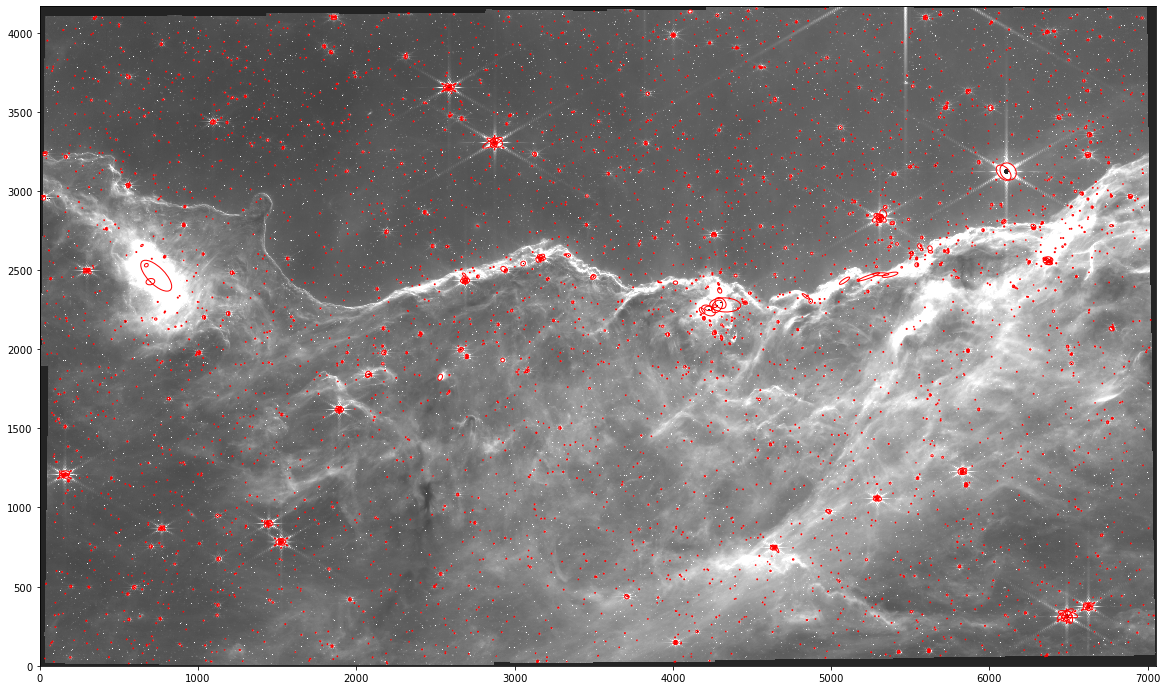

In [8]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots(figsize=(20,15))
m, s = np.mean(data), np.std(data)
im = ax.imshow(data, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

# Cutout

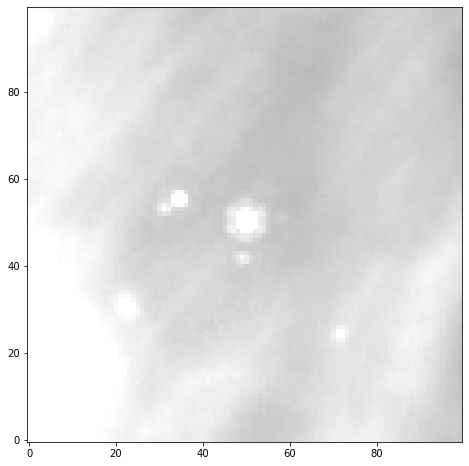

In [9]:
data_sub[4153][5975]

from astropy.nddata import Cutout2D

position = (965, 2361)
size = (100, 100)     # pixels
cutout = Cutout2D(data, position, size)
# Make the cutout, including the WCS
cutout = Cutout2D(data, position=position, size=size, wcs=wcs_im)


# # Put the cutout image in the FITS HDU
# hdu.data = cutout.data

# # Update the FITS header with the cutout WCS
# hdu.header.update(cutout.wcs.to_header())

plt.imshow(cutout.data, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')
# cutout

4  objects were detected in  f444w


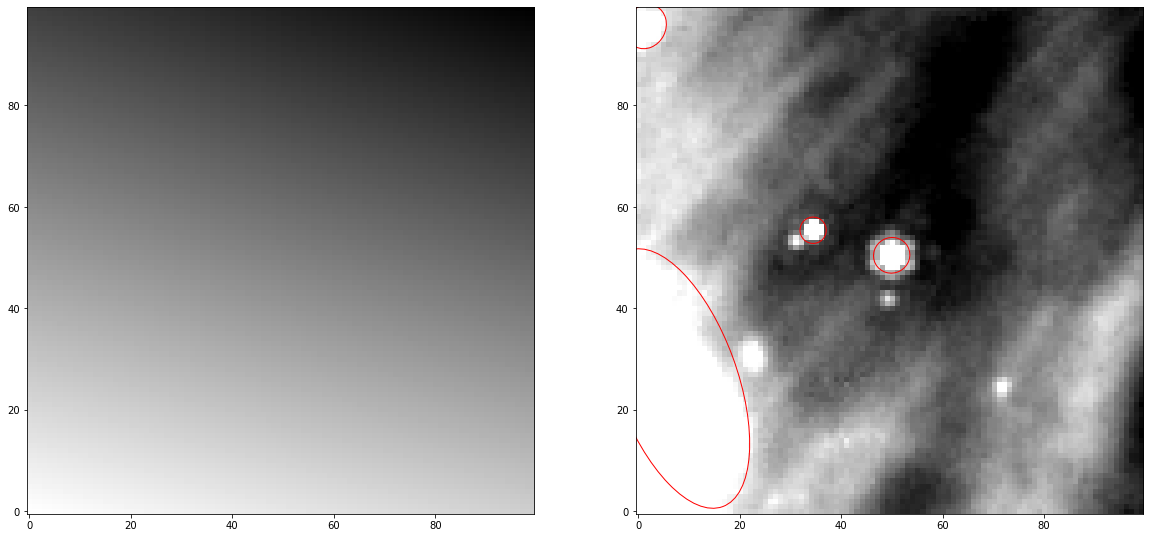

In [10]:
cutout_data = cutout.data.copy(order='C')
bkg_cutout = sep.Background(cutout_data)

objects_cutout = sep.extract(cutout_data-bkg_cutout, 2.5, err=bkg_cutout.globalrms)

# how many objects were detected
print(len(objects_cutout), " objects were detected in ", filt)


# View object
# plot background-subtracted image
fig, ax = plt.subplots(1,2,figsize=(20,15))
m, s = np.mean(cutout_data), np.std(cutout_data)
im = ax[1].imshow(cutout_data, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects_cutout)):
    e = Ellipse(xy=(objects_cutout['x'][i], objects_cutout['y'][i]),
                width=6*objects_cutout['a'][i],
                height=6*objects_cutout['b'][i],
                angle=objects_cutout['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax[1].add_artist(e)

# View background
ax[0].imshow(bkg_cutout, interpolation='nearest', cmap='gray', origin='lower')

In [11]:

import astropy.wcs as wcs
radec = cutout.wcs.pixel_to_world(objects_cutout['x'],objects_cutout['y'])
radec


<SkyCoord (ICRS): (ra, dec) in deg
    [(159.20158228, -58.66555528), (159.20270069, -58.66492568),
     (159.20274545, -58.6652092 ), (159.20381287, -58.66592952)]>

# Match to other filters

In [12]:
# i = 1
from astropy.coordinates import match_coordinates_sky
import astropy.units as u
from astropy.coordinates import SkyCoord 
from astropy.table import Table
import pandas as pd
import warnings

warnings.filterwarnings('ignore')
data = [fits.open(imagefiles[filt])[1].data for filt in filters]
w_jwst = [wcs.WCS(fits.open(imagefiles[filt])[1].header) for filt in filters]
tables = [Table.read(imagefiles[filt].split('i2d')[0]+'cat.ecsv') for filt in filters]
vmax = [10,90,40,10,10,10,150,150,150,300]
scale = [0.031,0.031,0.031,0.063,0.063,0.063,0.11,0.11,0.11,0.11]



csv_1sig = pd.read_csv('CC_Catalog_May112023_SPICY_Preds.csv')
cc_match = pd.read_csv('CC_Catalog_2_5sigFeb172023_SPICY_Preds.csv')

sky_1sig = SkyCoord(csv_1sig.RA*u.deg, csv_1sig.DEC*u.deg)
sky_2_5sig = SkyCoord(cc_match.RA*u.deg, cc_match.DEC*u.deg)
# Set tolerance - matched objects that are at most this far apart are considered one object
# tol = 0.005 #in degrees #max(catalog['size'])
# Match
idx, sep2d, _ = match_coordinates_sky(sky_2_5sig, sky_1sig, nthneighbor=1, storekdtree='kdtree_sky')
# print(idx)
cc_1sig = csv_1sig.iloc[idx]

In [13]:
cc_1sig['SPICY'][np.where(cc_1sig['SPICY_Class_0/1'].values==0)[0]]

6      7454.0
16     7476.0
52     7434.0
68     7441.0
84     7465.0
106    7469.0
108    7475.0
111    7438.0
112    7477.0
117    7423.0
128    7428.0
129    7482.0
135    7481.0
155    7461.0
225    7473.0
307    7479.0
313    7452.0
314    7464.0
333    7435.0
350    7444.0
355    7448.0
356    7409.0
388    7467.0
407    7447.0
416    7462.0
445    7440.0
Name: SPICY, dtype: float64

In [14]:

# import matplotlib.patches as patches
# # for i in np.where(cc_1sig['SPICY_Class_0/1'].values==0)[0]:
# i=6
# l = 0 
# fig, axs = plt.subplots(2,5,figsize=(20,10))

# flux = ["%.2f" % cc_match[[f'isophotal_vegamag_{filt}']].iloc[i] for filt in filters]
# flux_1sig = ["%.2f" % cc_1sig[[f'isophotal_flux_{filt}']].iloc[i] for filt in filters]
# flux_s = [np.nan, np.nan, np.nan,"%.2f" %  cc_match[['mag_IR1']].iloc[i],"%.2f" %  cc_match[['mag_IR2']].iloc[i], np.nan,"%.2f" %  cc_match[['mag_IR4']].iloc[i],np.nan,np.nan,np.nan]
# for j in [0,1,2,3,4]:
#     for k in [0,1]:
#         # if l < len(match_pot):
#         x, y = w_jwst[l].world_to_pixel(SkyCoord(cc_match.RA.iloc[i], cc_match.DEC.iloc[i],unit='deg'))
#         x_1, y_1 = w_jwst[l].world_to_pixel(SkyCoord(cc_1sig.RA.iloc[i], cc_1sig.DEC.iloc[i],unit='deg'))
#         x_s, y_s = w_jwst[l].world_to_pixel(SkyCoord(cc_match.RAJ2000.iloc[i], cc_match.DEJ2000.iloc[i],unit='deg'))
#         box_set = 50

#         axs[k][j].imshow(data[l],vmax=vmax[l],origin='lower')



#         # Plot boxes on top of image
#         circle = patches.Circle((x_1,y_1),cc_1sig['size'].iloc[i]*3600/scale[l],linewidth=1,edgecolor='k',facecolor='none')
#         circle_2_5 = patches.Circle((x,y),2.5*cc_match['size'].iloc[i]*3600/scale[l],linewidth=1,edgecolor='w',facecolor='none')
#         box_s = patches.Rectangle((x_s-15, y_s-15), 30, 30, linewidth=1, edgecolor='r', facecolor='none')
#         axs[k][j].add_patch(circle)
#         axs[k][j].add_patch(circle_2_5)
#         axs[k][j].add_patch(box_s)


#         axs[k][j].set_xlim(x_1-box_set,x_1+box_set)
#         axs[k][j].set_ylim(y_1-box_set,y_1+box_set)

#         axs[k][j].plot(tables[l]['xcentroid'],tables[l]['ycentroid'],'*',alpha=0.8,markersize=18,color='orange')
#         axs[k][j].set_title(filters[l])
#         axs[k][j].legend(labels= [flux_1sig[l],flux[l], flux_s[l], 'In band'])
#         axs[k][j].grid(False)
#         l += 1
# print(i)
# # plt.showfig()
# # plt.savefig(f'./Figures/sigma_flux_comparison_SPICY_{int(cc_match.SPICY.iloc[i])}'+date+'.png',dpi=300)
# i+=1

In [15]:
def fill_saturated_pix(cutout_data):
    nanx, nany = np.where(cutout_data==0)
    if len(nanx) > 0:
        # print(max(cutout_data.ravel()))
        fluxes_xy = cutout_data[[min(nanx)-n for n in range(1,5)], [min(nany)-n for n in range(1,5)]]
        mu_nanx, mu_nany = np.mean(nanx), np.mean(nany)
        
        # Fit gaussian to hold new flux values
        gauss3d = max(cutout_data.ravel()) * np.exp(-(((nanx-mu_nanx)**2+(nany-mu_nany)**2)/(2*np.std(fluxes_xy)**2))) #/(2*np.pi) * (1/np.std(fluxes_xy))
        # gauss3d = 1/(2*np.pi) * (1/np.sqrt(np.std(fluxes_x)**2+np.std(fluxes_y)**2)) * np.exp(-((nanx-mu_nanx)**2/(2*np.std(fluxes_x)**2)+(nany-mu_nany)**2/(2*np.std(fluxes_y)**2)))
        cutout_data[nanx,nany] = gauss3d

    return cutout_data



<Figure size 720x576 with 0 Axes>

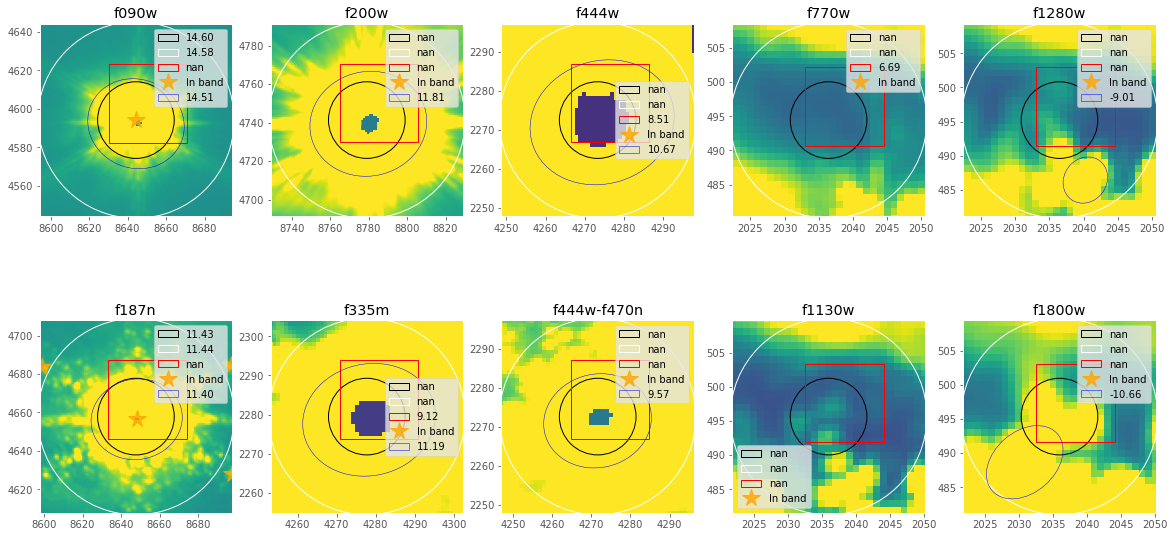

In [73]:
i = 445

data = [fits.open(imagefiles[filt])[1].data for filt in filters]
w_jwst = [wcs.WCS(fits.open(imagefiles[filt])[1].header) for filt in filters]
tables = [Table.read(imagefiles[filt].split('i2d')[0]+'cat.ecsv') for filt in filters]
pixar_srs = [fits.open(imagefiles[filt])[1].header['PIXAR_SR'] for filt in filters]
photmjsrs = [fits.open(imagefiles[filt])[1].header['PHOTMJSR'] for filt in filters]
vmax = [10,90,40,10,10,10,150,150,150,300]
scale = [0.031,0.031,0.031,0.063,0.063,0.063,0.11,0.11,0.11,0.11]
f_zps = [26.29,22.37,25.60,23.78,24.30,20.22,0,0,0,0] # Still need MIRI zero-points
date = 'May172023_BCPhot'
# for i in np.where(cc_1sig['SPICY_Class_0/1'].values==0)[0]:
l = 0 
plt.figure(l)
fig, axs = plt.subplots(2,5,figsize=(20,10))

flux = ["%.2f" % cc_match[[f'isophotal_vegamag_{filt}']].iloc[i] for filt in filters]
flux_1sig = ["%.2f" % cc_1sig[[f'isophotal_vegamag_{filt}']].iloc[i] for filt in filters]
flux_s = [np.nan, np.nan, np.nan,"%.2f" %  cc_match[['mag_IR1']].iloc[i],"%.2f" %  cc_match[['mag_IR2']].iloc[i], np.nan,"%.2f" %  cc_match[['mag_IR4']].iloc[i],np.nan,np.nan,np.nan]
# f_zps = [2244.95, 794.85, 757.65, 298.91, 184.10, 159.5, 65.08, 29.66, 23.52, 11.99]


zps_new = np.zeros(len(filters))
for j in [0,1,2,3,4]:
    for k in [0,1]:
        # if l < len(match_pot):
        x, y = w_jwst[l].world_to_pixel(SkyCoord(cc_match.RA.iloc[i], cc_match.DEC.iloc[i],unit='deg'))
        x_1, y_1 = w_jwst[l].world_to_pixel(SkyCoord(cc_1sig.RA.iloc[i], cc_1sig.DEC.iloc[i],unit='deg'))
        x_s, y_s = w_jwst[l].world_to_pixel(SkyCoord(cc_match.RAJ2000.iloc[i], cc_match.DEJ2000.iloc[i],unit='deg'))

        box_set = 50*1/(scale[l]/0.031)


        m, s = np.mean(data[l]), np.std(data[l])
        axs[k][j].imshow(data[l],vmax=m+s,vmin=m-s,origin='lower')

        axs[k][j].set_xlim(x_1-box_set,x_1+box_set)
        axs[k][j].set_ylim(y_1-box_set,y_1+box_set)
        axs[k][j].set_title(filters[l])
        axs[k][j].grid(False)

        if (x_1 > box_set and x_1 < np.shape(data[l])[1]-box_set) and (y_1 > box_set and y_1 < np.shape(data[l])[0]-box_set):

            # Plot boxes on top of image
            circle = patches.Circle((x_1,y_1),cc_1sig['size'].iloc[i]*3600/scale[l],linewidth=1,edgecolor='k',facecolor='none')
            circle_2_5 = patches.Circle((x,y),2.5*cc_match['size'].iloc[i]*3600/scale[l],linewidth=1,edgecolor='w',facecolor='none')
            box_s = patches.Rectangle((x_s-cc_match['size'].iloc[i]*3600/scale[l], y_s-cc_match['size'].iloc[i]*3600/scale[l]), 2*cc_match['size'].iloc[i]*3600/scale[l], 2*cc_match['size'].iloc[i]*3600/scale[l], linewidth=1, edgecolor='r', facecolor='none')
            axs[k][j].add_patch(circle)
            axs[k][j].add_patch(circle_2_5)
            axs[k][j].add_patch(box_s)


            axs[k][j].plot(tables[l]['xcentroid'],tables[l]['ycentroid'],'*',alpha=0.8,markersize=18,color='orange')

            
            axs[k][j].legend(labels= [flux_1sig[l],flux[l], flux_s[l], 'In band'])

            position = (x_1, y_1)       
            size = (2*box_set, 2*box_set)     # pixels
            tmp_cut_data = data[l].byteswap().newbyteorder()
            cutout = Cutout2D(tmp_cut_data, position, size, w_jwst[l])
            cutout_data = cutout.data.copy(order='C')
            fill_saturated_pix(cutout_data)
            if l == 3:
                cut_dat_test = cutout_data
            bkg_cutout = sep.Background(cutout_data)

            objects_cutout = sep.extract(cutout_data-bkg_cutout, 2, err=bkg_cutout.globalrms)

            # how many objects were detected
            # print(len(objects_cutout), " objects were detected in ", filters[l])


            # plot an ellipse for each object
            e = []
            cmag = []
            min_cut = 10
            sep_ind = -1
            for c in range(len(objects_cutout)):
                objects_cutout['x'][c] = objects_cutout['x'][c]+(x_1-box_set)
                objects_cutout['y'][c] = objects_cutout['y'][c]+(y_1-box_set)
                # cmag.append(-2.5*np.log10(objects_cutout['flux'][c]*pixar_srs[l]/f_zps[l]))
                cmag.append("%.2f" % float(-2.5*np.log10(objects_cutout['flux'][c]/(photmjsrs[l]))+f_zps[l]))
                e.append(Ellipse(xy=(objects_cutout['x'][c], objects_cutout['y'][c]),
                            width=6*objects_cutout['a'][c],
                            height=6*objects_cutout['b'][c],
                            angle=objects_cutout['theta'][c] * 180. / np.pi, edgecolor='b', facecolor='none'))
                if ((objects_cutout['x'][c]-x_1)**2 + (objects_cutout['y'][c]-y_1)**2)**0.5 < min_cut:
                    min_cut = ((objects_cutout['x'][c]-x_1)**2 + (objects_cutout['y'][c]-y_1)**2)**0.5
                    sep_ind = c
                # e.set_facecolor('none')
                # e.set_edgecolor('blue')
                # axs[k][j].add_patch(e)
            if sep_ind > -1:
                axs[k][j].add_patch(e[sep_ind])
                axs[k][j].legend(labels= [flux_1sig[l],flux[l], flux_s[l], 'In band', cmag[sep_ind]])
            
        l += 1
        # zps_new[l] = (cc_1sig[[f'isophotal_vegamag_{filters[l]}']].iloc[i].values+2.5*np.log10(objects_cutout['flux'][sep_ind]/(photmjsrs[l])))


# plt.savefig('./Figures/sigma_flux_comparisons_'+date+f'/SPICY_{int(cc_match.SPICY.iloc[i])}'+date+'.png',dpi=300) 
plt.close(l) 

In [17]:
# print(np.where(np.isnan(data[3])))
# # len(np.where(np.isnan(data[3]))[0])
# print(np.where(np.where(np.isnan(data[3]))[1]==30))
# # print(np.where(np.isnan(data[3]))[np.where(np.where(np.isnan(data[3]))[1]==30)[0]][np.where(np.where(np.isnan(data[3]))[1]==30)[0]])
# np.where(np.isnan(data[3]))[0][np.where(np.where(np.isnan(data[3]))[1]==28)[0]]
# print(data[3][3152][29])
# print(data[3][3152][30])
# print(data[3][3152][40])
# print(data[3][3152][50])
# vals = plt.imshow(cut_dat_test, vmax=np.mean(data[3])+np.std(data[3]),vmin=np.mean(data[3])-np.std(data[3]),origin='lower')
# plt.colorbar()
# # plt.xlim(3148,3155)
# # plt.ylim(25,35)
# # print(data[3][3148:3155,25:35])
# vals

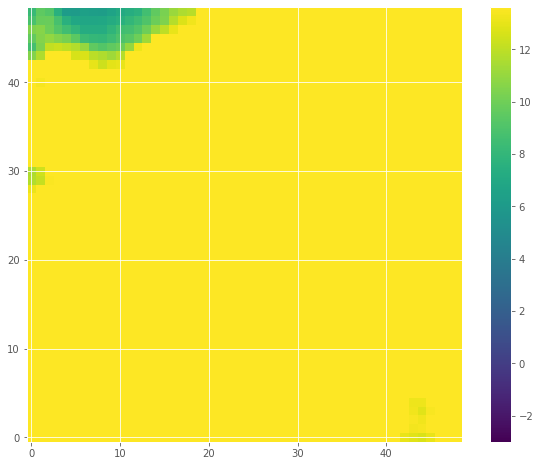

In [50]:
# cut_dat_test_fill = fill_saturated_pix(cut_dat_test.copy())
n = 3
plt.imshow(cut_dat_test, vmax=np.mean(data[n])+np.std(data[n]),vmin=np.mean(data[n])-np.std(data[n]),origin='lower')
plt.colorbar()

# Make catalogue.

* Take OG catalogue and keep all the RA/DEC and match info, but replace the fluxes with those calculated with cutouts/sextractor

In [20]:
new_cat = cc_1sig.copy()

new_cat.columns


Index(['Unnamed: 0', 'RA', 'DEC', 'size', 'isophotal_vegamag_f200w',
       'isophotal_vegamag_err_f200w', 'isophotal_vegamag_f090w',
       'isophotal_vegamag_err_f090w', 'isophotal_vegamag_f187n',
       'isophotal_vegamag_err_f187n', 'isophotal_vegamag_f335m',
       'isophotal_vegamag_err_f335m', 'isophotal_vegamag_f444w',
       'isophotal_vegamag_err_f444w', 'isophotal_vegamag_f444w-f470n',
       'isophotal_vegamag_err_f444w-f470n', 'isophotal_vegamag_f770w',
       'isophotal_vegamag_err_f770w', 'isophotal_vegamag_f1130w',
       'isophotal_vegamag_err_f1130w', 'isophotal_vegamag_f1280w',
       'isophotal_vegamag_err_f1280w', 'isophotal_vegamag_f1800w',
       'isophotal_vegamag_err_f1800w', 'RAJ2000', 'DEJ2000', 'mag_J',
       'e_mag_J', 'mag_H', 'e_mag_H', 'mag_Ks', 'e_mag_Ks', 'mag_IR1',
       'e_mag_IR1', 'mag_IR2', 'e_mag_IR2', 'mag_IR3', 'e_mag_IR3', 'mag_IR4',
       'e_mag_IR4', 'alpha', 'Preds', 'SPICY', 'SPICY_Class', 'SPICY_Prob',
       'SPICY_Class_0/1'],
      

In [67]:
i = 445

data = [fits.open(imagefiles[filt])[1].data for filt in filters]
w_jwst = [wcs.WCS(fits.open(imagefiles[filt])[1].header) for filt in filters]
# tables = [Table.read(imagefiles[filt].split('i2d')[0]+'cat.ecsv') for filt in filters]
pixar_srs = [fits.open(imagefiles[filt])[1].header['PIXAR_SR'] for filt in filters]
photmjsrs = [fits.open(imagefiles[filt])[1].header['PHOTMJSR'] for filt in filters]
scale = [0.031,0.031,0.031,0.063,0.063,0.063,0.11,0.11,0.11,0.11]
f_zps = [26.29,22.37,25.60,23.78,24.30,20.22,0,0,0,0] # Still need MIRI zero-points
date = 'May172023_BCPhot'
# for i in np.where(cc_1sig['SPICY_Class_0/1'].values==0)[0]:
l = 0 
# plt.figure(l)
# fig, axs = plt.subplots(2,5,figsize=(20,10))

flux = ["%.2f" % cc_match[[f'isophotal_vegamag_{filt}']].iloc[i] for filt in filters]
flux_1sig = ["%.2f" % cc_1sig[[f'isophotal_vegamag_{filt}']].iloc[i] for filt in filters]
flux_s = [np.nan, np.nan, np.nan,"%.2f" %  cc_match[['mag_IR1']].iloc[i],"%.2f" %  cc_match[['mag_IR2']].iloc[i], np.nan,"%.2f" %  cc_match[['mag_IR4']].iloc[i],np.nan,np.nan,np.nan]
# f_zps = [2244.95, 794.85, 757.65, 298.91, 184.10, 159.5, 65.08, 29.66, 23.52, 11.99]

for i in range(0,len(new_cat)):
    for l in range(0,len(filters)):
        # x, y = w_jwst[l].world_to_pixel(SkyCoord(cc_match.RA.iloc[i], cc_match.DEC.iloc[i],unit='deg'))
        x_1, y_1 = w_jwst[l].world_to_pixel(SkyCoord(cc_1sig.RA.iloc[i], cc_1sig.DEC.iloc[i],unit='deg'))
        x_s, y_s = w_jwst[l].world_to_pixel(SkyCoord(cc_match.RAJ2000.iloc[i], cc_match.DEJ2000.iloc[i],unit='deg'))
        mag = cc_1sig[[f'isophotal_vegamag_{filters[l]}']].iloc[i].values[0]
        box_set = 50*1/(scale[l]/0.031)

        # Cutout and source extract only for sources in frame
        if (x_1 > box_set and x_1 < np.shape(data[l])[1]-box_set) and (y_1 > box_set and y_1 < np.shape(data[l])[0]-box_set):
            position = (x_1, y_1)       
            size = (2*box_set, 2*box_set)     # pixels
            tmp_cut_data = data[l].byteswap().newbyteorder()
            cutout = Cutout2D(tmp_cut_data, position, size, w_jwst[l])
            cutout_data = cutout.data.copy(order='C')
            fill_saturated_pix(cutout_data)
            bkg_cutout = sep.Background(cutout_data)

            objects_cutout = sep.extract(cutout_data-bkg_cutout, 2, err=bkg_cutout.globalrms)

            # how many objects were detected
            # print(len(objects_cutout), " objects were detected in ", filters[l])


            # plot an ellipse for each object
            e = []
            cmag = []
            min_cut = 10
            sep_ind = -1
            for c in range(len(objects_cutout)):
                objects_cutout['x'][c] = objects_cutout['x'][c]+(x_1-box_set)
                objects_cutout['y'][c] = objects_cutout['y'][c]+(y_1-box_set)
                # cmag.append(-2.5*np.log10(objects_cutout['flux'][c]*pixar_srs[l]/f_zps[l]))
                cmag.append(float(-2.5*np.log10(objects_cutout['flux'][c]/(photmjsrs[l]))+f_zps[l]))
                if ((objects_cutout['x'][c]-x_1)**2 + (objects_cutout['y'][c]-y_1)**2)**0.5 < min_cut:
                    min_cut = ((objects_cutout['x'][c]-x_1)**2 + (objects_cutout['y'][c]-y_1)**2)**0.5
                    sep_ind = c

            if sep_ind > -1:
                mag = cmag[sep_ind]
            # else: 
            #     print(mag)
                
        new_cat[f'isophotal_vegamag_{filters[l]}'].iloc[i] = mag

        l += 1


new_cat.to_csv('CC_Catalog_May172023_BCPhot_SPICY_Preds.csv')

In [40]:
i

392

In [21]:
objects_cutout

array([(41.12808228, 619, 569,  7, 43,  7, 38, 4271.57983264, 2271.54536542, 21.07443273, 16.13744241, 1.21689955, 0.00028215, 0.00019406, 3.01693576e-05, 4.62148094, 3.98168182, 0.2290048 , 0.04765838, 0.06223869, -0.00718769, 251613.9375    , 252484.640625  , 3207.92773438, 3207.9296875 , 24, 23, 21, 25, 0),
       (41.12808228, 120, 110, 38, 48, 30, 48, 4292.60436752, 2289.5810786 ,  4.50279161, 24.58368147, 0.98085523, 0.00249894, 0.0143771 , 4.17746494e-04, 4.96301079, 2.11068606, 1.52210557, 0.22403155, 0.04103402, -0.01787711,  10877.48535156,  12149.29785156,  278.27502441,  479.66217041, 48, 46, 48, 46, 2)],
      dtype=[('thresh', '<f8'), ('npix', '<i8'), ('tnpix', '<i8'), ('xmin', '<i8'), ('xmax', '<i8'), ('ymin', '<i8'), ('ymax', '<i8'), ('x', '<f8'), ('y', '<f8'), ('x2', '<f8'), ('y2', '<f8'), ('xy', '<f8'), ('errx2', '<f8'), ('erry2', '<f8'), ('errxy', '<f8'), ('a', '<f8'), ('b', '<f8'), ('theta', '<f8'), ('cxx', '<f8'), ('cyy', '<f8'), ('cxy', '<f8'), ('cflux', '<f8'), (

In [68]:
new_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 446 entries, 0 to 445
Data columns (total 46 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         446 non-null    int64  
 1   RA                                 446 non-null    float64
 2   DEC                                446 non-null    float64
 3   size                               446 non-null    float64
 4   isophotal_vegamag_f200w            436 non-null    object 
 5   isophotal_vegamag_err_f200w        290 non-null    float64
 6   isophotal_vegamag_f090w            431 non-null    object 
 7   isophotal_vegamag_err_f090w        306 non-null    float64
 8   isophotal_vegamag_f187n            427 non-null    object 
 9   isophotal_vegamag_err_f187n        377 non-null    float64
 10  isophotal_vegamag_f335m            405 non-null    object 
 11  isophotal_vegamag_err_f335m        359 non-null    float64

## CMDs

26
420


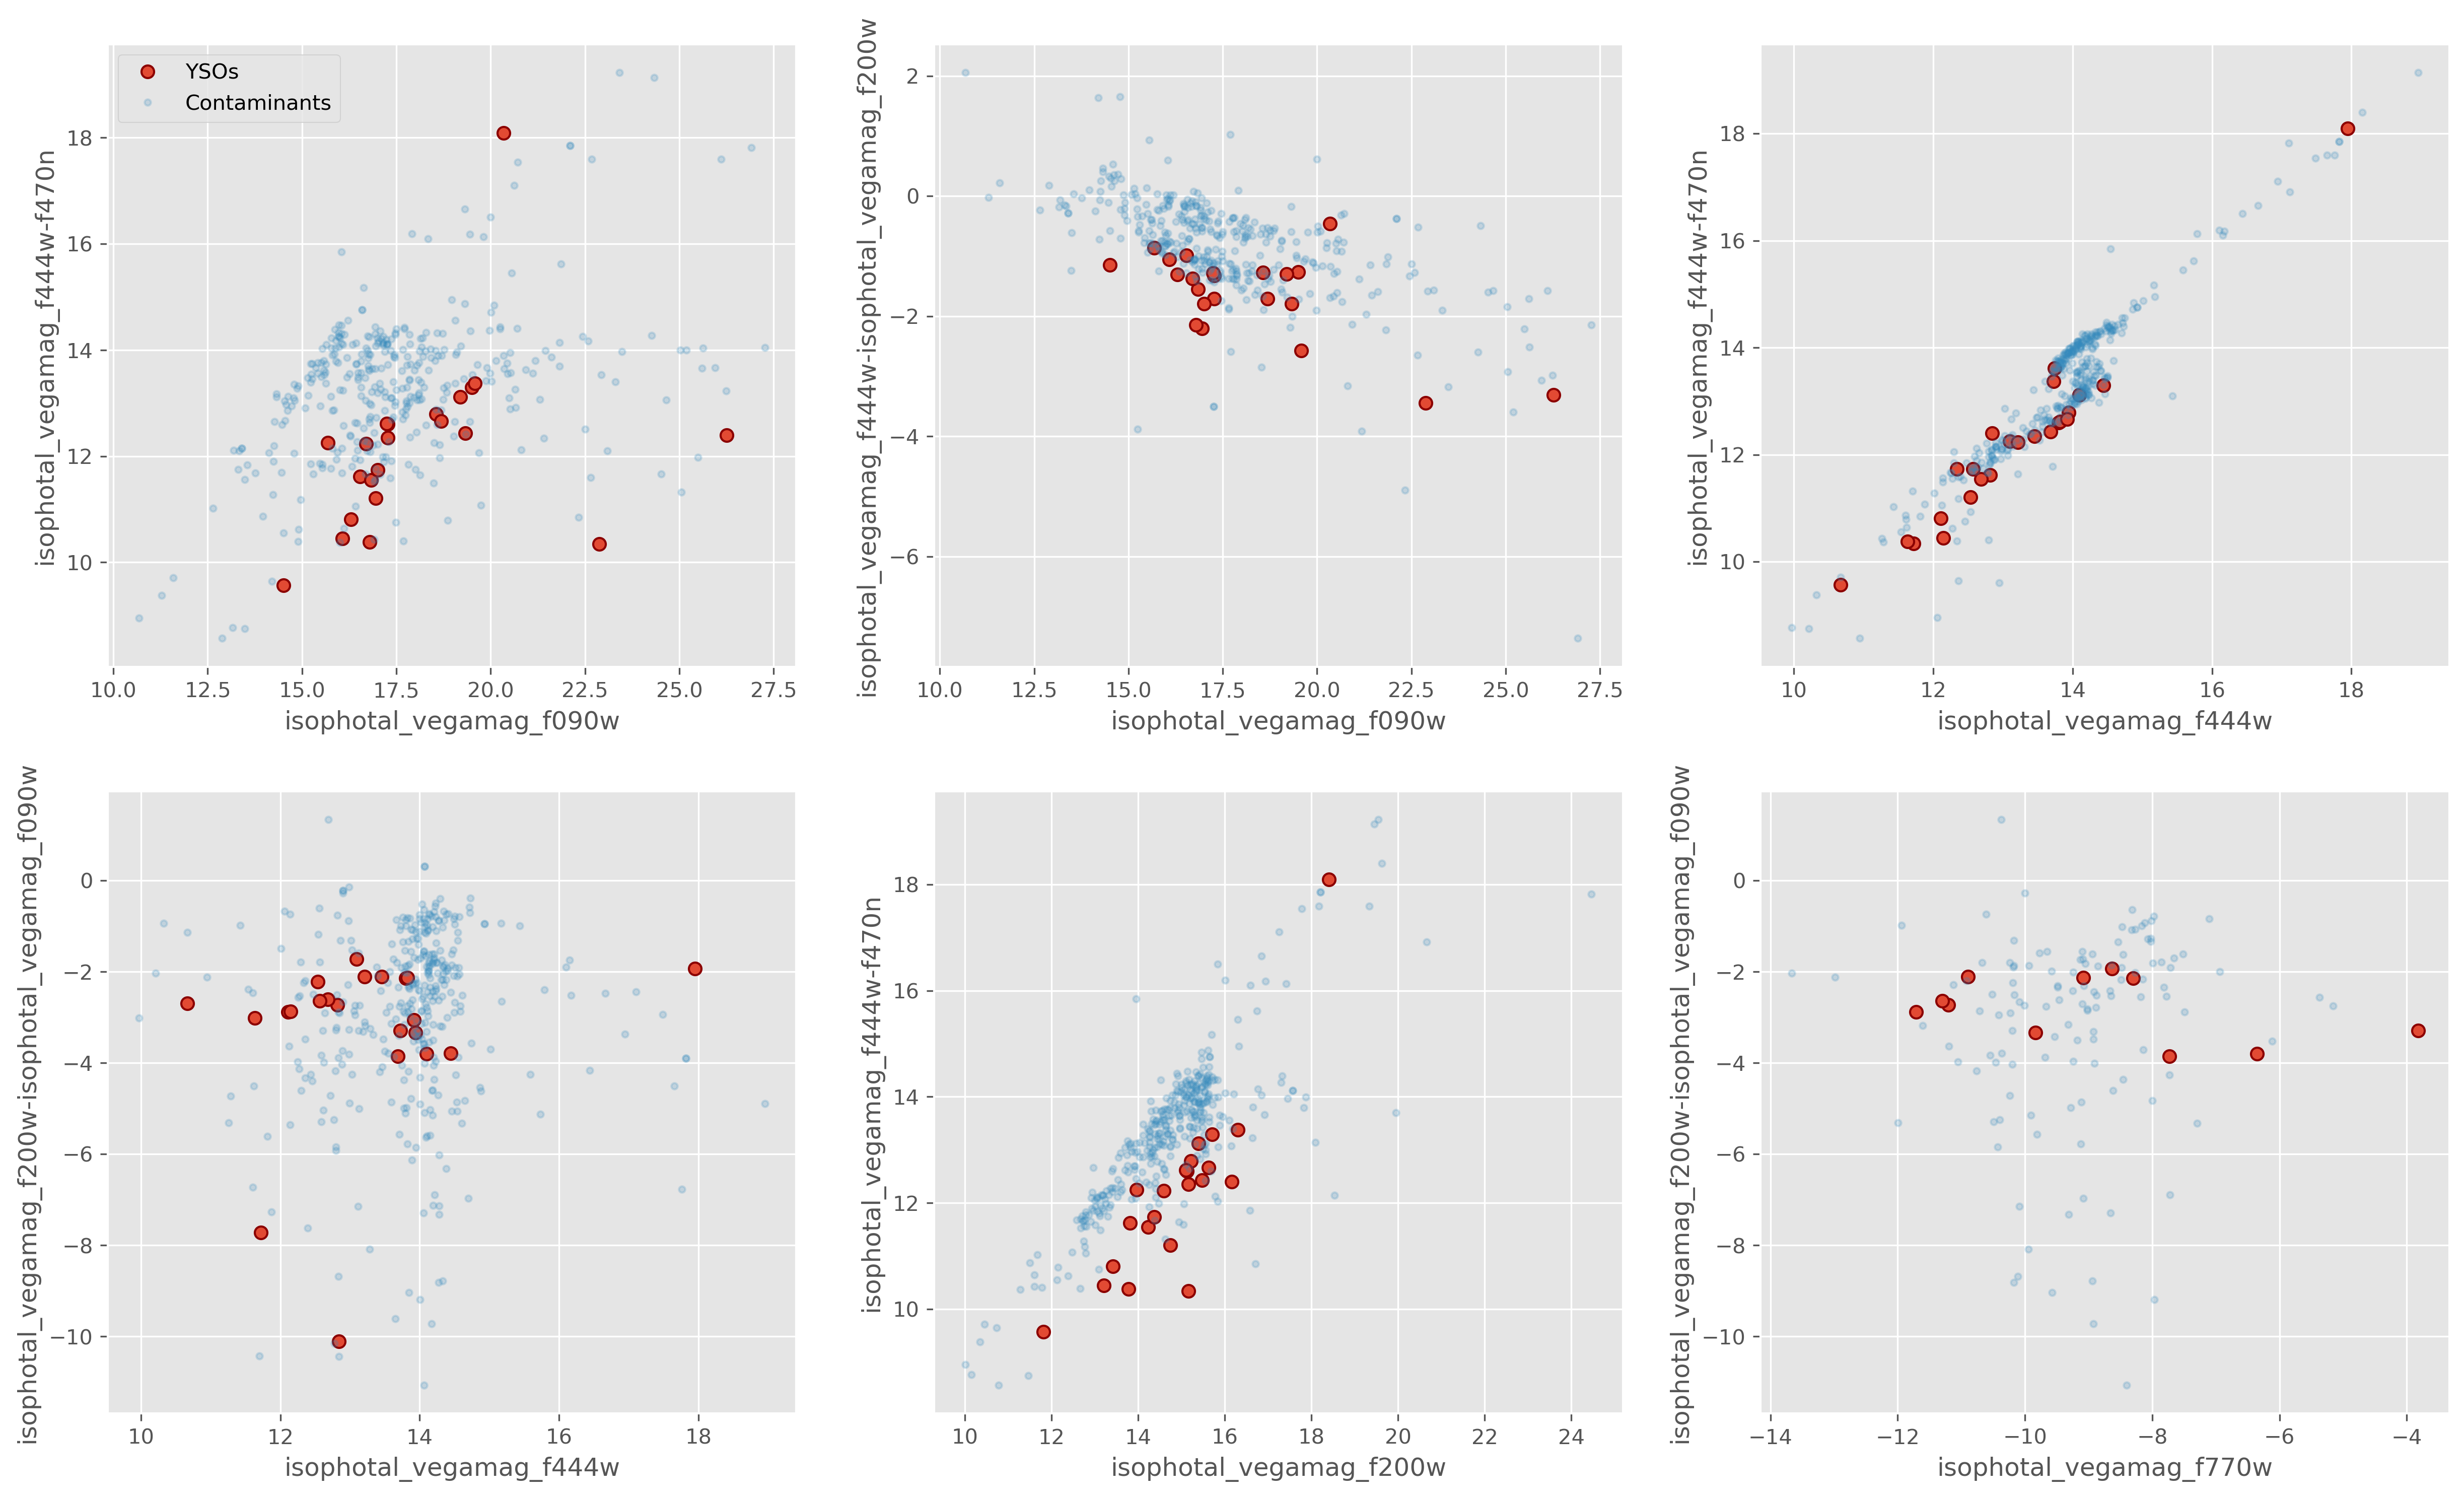

In [72]:
CC_Webb_Classified = new_cat
ysos = CC_Webb_Classified[CC_Webb_Classified['SPICY_Class_0/1']==0]
cont = CC_Webb_Classified[CC_Webb_Classified['SPICY_Class_0/1']==1]
print(len(ysos))
print(len(cont))
band1 = "isophotal_vegamag_f090w"
band2 = "isophotal_vegamag_f187n"
band3 = "isophotal_vegamag_f200w"
band4 = "isophotal_vegamag_f335m"
band5 = "isophotal_vegamag_f444w"
band6 = "isophotal_vegamag_f444w-f470n"
band7 = "isophotal_vegamag_f770w"
band8 = "isophotal_vegamag_f1130w"
band9 = "isophotal_vegamag_f1280w"
band10 = "isophotal_vegamag_f1800w"


plt.style.use('ggplot')
fig, axs = plt.subplots(2,3,figsize=(20,12),dpi=300)
axs[0][0].plot(ysos[band1],ysos[band6],'.',markersize=12,markeredgecolor='darkred',label='YSOs')
axs[0][0].plot(cont[band1],cont[band6],'.',alpha=0.2,label='Contaminants')
axs[0][0].set_xlabel(band1)
axs[0][0].set_ylabel(band6)
axs[0][1].plot(ysos[band1],ysos[band5]-ysos[band3],'.',markersize=12,markeredgecolor='darkred',label='YSOs')
axs[0][1].plot(cont[band1],cont[band5]-cont[band3],'.',alpha=0.2,label='Contaminants')
axs[0][1].set_xlabel(band1)
axs[0][1].set_ylabel(band5+"-"+band3)
axs[0][2].plot(ysos[band5],ysos[band6],'.',markersize=12,markeredgecolor='darkred',label='YSOs')
axs[0][2].plot(cont[band5],cont[band6],'.',alpha=0.2,label='Contaminants')
axs[0][2].set_xlabel(band5)
axs[0][2].set_ylabel(band6)

axs[1][1].plot(ysos[band3],ysos[band6],'.',markersize=12,markeredgecolor='darkred',label='YSOs')
axs[1][1].plot(cont[band3],cont[band6],'.',alpha=0.2,label='Contaminants')
axs[1][1].set_xlabel(band3)
axs[1][1].set_ylabel(band6)
axs[1][0].plot(ysos[band5],ysos[band3]-ysos[band1],'.',markersize=12,markeredgecolor='darkred',label='YSOs')
axs[1][0].plot(cont[band5],cont[band3]-cont[band1],'.',alpha=0.2,label='Contaminants')
axs[1][0].set_xlabel(band5)
axs[1][0].set_ylabel(band3+"-"+band1)
axs[1][2].plot(ysos[band7],ysos[band3]-ysos[band1],'.',markersize=12,markeredgecolor='darkred',label='YSOs')
axs[1][2].plot(cont[band7],cont[band3]-cont[band1],'.',alpha=0.2,label='Contaminants')
axs[1][2].set_xlabel(band7)
axs[1][2].set_ylabel(band3+"-"+band1)
# axs[1][0].plot(cont[band7],cont[band10]-cont[band7],'.',label='Contaminants')
# axs[1][0].plot(ysos[band7],ysos[band10]-ysos[band7],'.',label='YSOs')
# axs[1][0].set_xlabel(band7)
# axs[1][0].set_ylabel(band10+"-"+band7)

axs[0][0].legend()

# plt.savefig('./Figures/cmds_2_5sig_FEb172023.png',dpi=300)

In [32]:
CC_Webb_Classified.iloc[5]

Unnamed: 0                                    5
RA                                   159.288177
DEC                                   -58.59467
size                                   0.000034
isophotal_vegamag_f200w               11.814448
isophotal_vegamag_err_f200w                 NaN
isophotal_vegamag_f090w               14.509604
isophotal_vegamag_err_f090w                 NaN
isophotal_vegamag_f187n               11.403208
isophotal_vegamag_err_f187n            0.001135
isophotal_vegamag_f335m               11.190594
isophotal_vegamag_err_f335m            0.001304
isophotal_vegamag_f444w                10.66641
isophotal_vegamag_err_f444w            0.000854
isophotal_vegamag_f444w-f470n          9.569643
isophotal_vegamag_err_f444w-f470n      0.001274
isophotal_vegamag_f770w                     NaN
isophotal_vegamag_err_f770w                 NaN
isophotal_vegamag_f1130w                    NaN
isophotal_vegamag_err_f1130w                NaN
isophotal_vegamag_f1280w                

In [74]:
imagefiles

{'f090w': '../../ngc3324/NIRCAM_ALL_May112023/JWST/jw02731-o001_t017_nircam_clear-f090w/jw02731-o001_t017_nircam_clear-f090w_i2d.fits',
 'f187n': '../../ngc3324/NIRCAM_ALL_May112023/JWST/jw02731-o001_t017_nircam_clear-f187n/jw02731-o001_t017_nircam_clear-f187n_i2d.fits',
 'f200w': '../../ngc3324/NIRCAM_ALL_May112023/JWST/jw02731-o001_t017_nircam_clear-f200w/jw02731-o001_t017_nircam_clear-f200w_i2d.fits',
 'f335m': '../../ngc3324/NIRCAM_ALL_May112023/JWST/jw02731-o001_t017_nircam_clear-f335m/jw02731-o001_t017_nircam_clear-f335m_i2d.fits',
 'f444w': '../../ngc3324/NIRCAM_ALL_May112023/JWST/jw02731-o001_t017_nircam_clear-f444w/jw02731-o001_t017_nircam_clear-f444w_i2d.fits',
 'f444w-f470n': '../../ngc3324/NIRCAM_ALL_May112023/JWST/jw02731-o001_t017_nircam_f444w-f470n/jw02731-o001_t017_nircam_f444w-f470n_i2d.fits',
 'f770w': '../../ngc3324/MIRI_ALL_May112023/JWST/jw02731-o002_t017_miri_f770w/jw02731-o002_t017_miri_f770w_i2d.fits',
 'f1130w': '../../ngc3324/MIRI_ALL_May112023/JWST/jw02731-o0

In [78]:
for filt in filters:
    tmp_fits = fits.open(imagefiles[filt])[1]
    fits.writeto(f'../../ngc3324/{filt}.fits',tmp_fits.data, tmp_fits.header)

    

In [77]:
!ls ../../


JWST                                  Thesis
Non-tracked_Notebooks                 YSO+Classification
Presentations                         ngc3324
Supervisory_Committee_Meeting_1.pages
